### 環境初始化與套件載入  
掛載 Google Drive、切換目錄，並載入所需的 Python 套件，包括資料處理、嵌入模型、主題建模、分類器與繪圖模組。


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/SMA/project3') #切換該目錄
os.listdir() #確認目錄內容

Mounted at /content/drive


['Project3.ipynb',
 'classification_with_embeddings_group11.ipynb',
 'TaipeiSansTCBeta-Regular.ttf',
 'EBC',
 'dict',
 'gpt_api_key.txt',
 'bert.ipynb']

In [ ]:
# !pip install -U sentence-transformers

In [ ]:
# !pip install bertopic

In [ ]:
# !pip install openai

In [ ]:
import pandas as pd
import re
from sentence_transformers import SentenceTransformer, models, util
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np
from matplotlib.font_manager import fontManager
import jieba
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from openai import OpenAI
import time
from tqdm import tqdm

### 環境初始化與套件載入  
掛載 Google Drive、切換目錄，並載入所需的 Python 套件，包括資料處理、嵌入模型、主題建模、分類器與繪圖模組。


In [ ]:
# 設定字體
fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.rcParams['font.size'] = '16'

### 載入中文語意嵌入模型（BERT）
使用 `SentenceTransformer` 載入 `google-bert/bert-base-chinese` 模型，將中文句子轉換為語意向量，作為主題建模與分類的基礎。


In [ ]:
# 中文 bert-base-chinese
bert_ch = SentenceTransformer('google-bert/bert-base-chinese', device='cuda')

bert_ch.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

0

### Step 1：資料讀取與清洗  
讀取多個 CSV 格式的新聞資料，合併成單一 DataFrame，並清除缺漏值、網址、非中文符號等雜訊資料。最終保留文章內容與分類欄位供後續使用。


In [ ]:
# 取得資料夾中所有EBC各版別之 CSV 檔案名稱
folder_path =("./EBC")
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# 讀取並合併
df_list = []
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    df_list.append(df)
ebc = pd.concat(df_list, ignore_index=True)

# 轉換日期欄位為 datetime 格式
ebc['artDate'] = pd.to_datetime(ebc['artDate'], errors='coerce')

# 顯示合併後的 DataFrame 前幾筆
ebc.head(3)

# 看看有幾篇文章
print(f"number of posts: {ebc.shape[0]}")
print(f"date range: {(ebc['artDate'].min(), ebc['artDate'].max())}")
print(f"category: \n{ebc['artCatagory'].value_counts()}")

number of posts: 6309
date range: (Timestamp('2024-09-01 06:00:00'), Timestamp('2025-02-28 22:57:00'))
category: 
artCatagory
國際    2644
體育    1621
財經     980
Name: count, dtype: int64


In [ ]:
# 過濾 nan 的資料
ebc=ebc.dropna(subset=['artTitle'])
ebc = ebc.dropna(subset=['artContent'])
# 移除網址格式
ebc["artContent"] = ebc.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
ebc["artTitle"] = ebc["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
ebc["artContent"] = ebc.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
ebc["artTitle"] = ebc["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
ebc.head(3)

# 留下 content
ebc["content"] = ebc["artTitle"] + ebc["artContent"]
ebc = ebc[["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結
ebc.head()

,content,artUrl,artCatagory
0,海景觀光殘破不堪國旅衰敗一片哀嚎賴清德總統曾喊出觀光立國的政見但年到月為止入出境觀光逆差已經...,https://news.ebc.net.tw/news/business/440092,財經
1,佳世達實施庫藏股跳空大漲台股量縮震盪漲百點台股今日開高震盪早盤指數最高來到點漲逾點隨後出現拉...,https://news.ebc.net.tw/news/business/440373,財經
2,人都去哪了台股再創新低量收跌點台股今日開高走低收點收跌點成交量縮減至億再創農曆年後最低量櫃買...,https://news.ebc.net.tw/news/business/440428,財經
3,大家不玩了台股平盤震盪估量僅億台股今日量縮震盪指數在平盤附近震盪早盤最低下探點跌逾點預估成交...,https://news.ebc.net.tw/news/business/440550,財經
4,快訊吳東亮涉滲透新光金有關鍵音檔北檢分案偵辦中新光金和台新金合併現在爆出有內鬼台北地檢署接到...,https://news.ebc.net.tw/news/business/440566,財經


### 生成嵌入向量  
將每篇文章的 `content` 轉換成語意向量，並存入新的欄位 `embeddings`，作為後續監督式學習與主題建模的輸入特徵。


In [ ]:
ebc["embeddings"] = ebc.content.apply(lambda x: bert_ch.encode(x))
ebc.head(3)

,content,artUrl,artCatagory,embeddings
0,海景觀光殘破不堪國旅衰敗一片哀嚎賴清德總統曾喊出觀光立國的政見但年到月為止入出境觀光逆差已經...,https://news.ebc.net.tw/news/business/440092,財經,"[0.4972598, -0.021271732, -0.09516859, 0.21490..."
1,佳世達實施庫藏股跳空大漲台股量縮震盪漲百點台股今日開高震盪早盤指數最高來到點漲逾點隨後出現拉...,https://news.ebc.net.tw/news/business/440373,財經,"[0.46630383, -0.11442908, -0.77415943, 0.37873..."
2,人都去哪了台股再創新低量收跌點台股今日開高走低收點收跌點成交量縮減至億再創農曆年後最低量櫃買...,https://news.ebc.net.tw/news/business/440428,財經,"[0.5071892, -0.031903733, -0.5426887, 0.264808..."


### Step 2：監督式分類模型訓練與評估  
將嵌入向量作為特徵，文章類別作為標籤，使用 4 種監督式模型（Logistic Regression、Decision Tree、SVM、Random Forest）進行五折交叉驗證，並輸出分類報告與混淆矩陣。


In [ ]:
import numpy as np
from ast import literal_eval

In [ ]:
data = ebc.copy()

X = data["embeddings"].apply(pd.Series)
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

           0         1         2         3         4         5         6    \
1113  0.433784 -0.167597 -0.055715  0.144849  0.013170 -0.179081 -0.021578   
3051  0.196818  0.057188 -0.068721  0.220140 -0.097643 -0.059463  0.031373   
1640  0.610920 -0.063231 -0.238010  0.250306 -0.077395 -0.363956  0.170794   
6075  0.339784 -0.264978 -0.404218 -0.028292  0.094855  0.019311  0.133041   
3915  0.491078 -0.243066 -0.320898  0.397925  0.002738 -0.063596 -0.142421   

           7         8         9    ...       758       759       760  \
1113  0.259486 -0.332629 -0.118738  ... -0.203510 -0.254922  0.081344   
3051  0.176571 -0.322203 -0.290317  ...  0.085174 -0.307107  0.074841   
1640  0.127581 -0.230564 -0.174639  ...  0.117371 -0.455117  0.053569   
6075  0.058468 -0.243618 -0.230758  ...  0.038889 -0.239554  0.249741   
3915  0.073776 -0.440095 -0.183398  ...  0.080345 -0.315782  0.008833   

           761       762       763       764       765       766       767  
1113 -0.052050 

In [ ]:
# 定義模型清單
model_set = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'DecisionTree': DecisionTreeClassifier(),
    'SVM': SVC(probability=True),
    'RandomForest': RandomForestClassifier()}
result_set = {}

def train_sbert_classifier(clf, X, y):
    # Cross-validation (5 folds)
    cv_results = cross_validate(clf, X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, X, y, cv=5, method="predict_proba")
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))
    classes = cv_results['estimator'][0].classes_
    cm = confusion_matrix(y, y_pred)
    # 畫 confusion matrix
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=classes, yticklabels=classes)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(f"{clf.__class__.__name__} Confusion Matrix")
    plt.yticks(rotation=0)
    plt.show()
    return cls_report

### 比較 F1-score 並選出最佳模型  
計算每個模型的 weighted average F1-score，選出表現最佳者，並在測試集上輸出最終的分類結果。


訓練模型：LogisticRegression
              precision    recall  f1-score   support

          國際       0.97      0.98      0.97      1864
          財經       0.95      0.93      0.94       676
          體育       0.99      0.99      0.99      1131

    accuracy                           0.97      3671
   macro avg       0.97      0.96      0.97      3671
weighted avg       0.97      0.97      0.97      3671



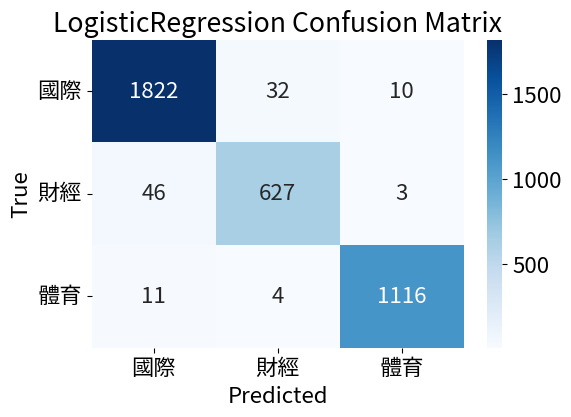

訓練模型：DecisionTree
              precision    recall  f1-score   support

          國際       0.89      0.88      0.89      1864
          財經       0.76      0.78      0.77       676
          體育       0.89      0.89      0.89      1131

    accuracy                           0.87      3671
   macro avg       0.85      0.85      0.85      3671
weighted avg       0.87      0.87      0.87      3671



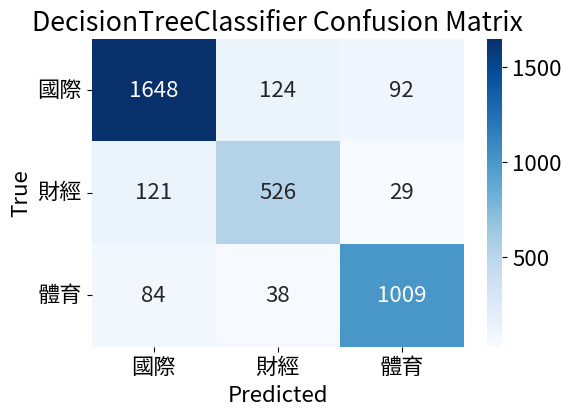

訓練模型：SVM
              precision    recall  f1-score   support

          國際       0.95      0.98      0.96      1864
          財經       0.95      0.88      0.91       676
          體育       0.99      0.98      0.99      1131

    accuracy                           0.96      3671
   macro avg       0.96      0.95      0.95      3671
weighted avg       0.96      0.96      0.96      3671



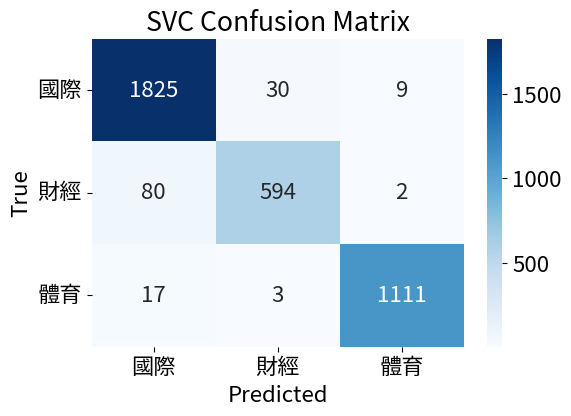

訓練模型：RandomForest
              precision    recall  f1-score   support

          國際       0.93      0.99      0.96      1864
          財經       0.96      0.84      0.89       676
          體育       0.99      0.96      0.98      1131

    accuracy                           0.95      3671
   macro avg       0.96      0.93      0.94      3671
weighted avg       0.95      0.95      0.95      3671



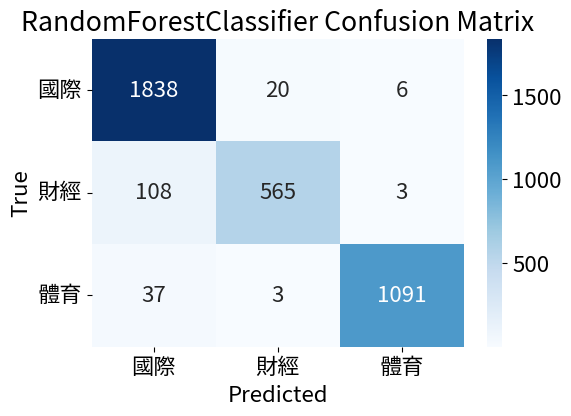


✅ 最佳模型：LogisticRegression，F1-score = 0.9711
{'accuracy': 0.9711250340506674,
 'macro avg': {'f1-score': 0.9658936793987939,
               'precision': 0.9679504860122893,
               'recall': 0.9639066681962368,
               'support': 3671.0},
 'weighted avg': {'f1-score': 0.9710632959824177,
                  'precision': 0.9710504270467287,
                  'recall': 0.9711250340506674,
                  'support': 3671.0},
 '國際': {'f1-score': 0.9735506278386321,
        'precision': 0.9696647152740819,
        'recall': 0.9774678111587983,
        'support': 1864.0},
 '財經': {'f1-score': 0.936519790888723,
        'precision': 0.9457013574660633,
        'recall': 0.9275147928994083,
        'support': 676.0},
 '體育': {'f1-score': 0.9876106194690265,
        'precision': 0.9884853852967228,
        'recall': 0.986737400530504,
        'support': 1131.0}}


In [ ]:
# 執行所有模型訓練 + 評估
for name, model in model_set.items():
    print("=" * 100)
    print(f"訓練模型：{name}")
    result_set[name] = train_sbert_classifier(model, X_train, y_train)
    print("=" * 100)

# 找出 F1-score 最佳模型
best_model_name = ""
max_f1 = 0
for name, report in result_set.items():
    if report['weighted avg']['f1-score'] > max_f1:
        max_f1 = report['weighted avg']['f1-score']
        best_model_name = name

print(f"\n✅ 最佳模型：{best_model_name}，F1-score = {max_f1:.4f}")
pprint(result_set[best_model_name])

In [ ]:
# Best model最後結果
final_clf = model_set[best_model_name]
final_clf.fit(X_train, y_train)
y_pred = final_clf.predict(X_test)
print(f"\n📊 Best model {best_model_name} 的測試集分類結果：")
print(classification_report(y_test, y_pred))
print(y_pred[:10])


📊 Best model LogisticRegression 的測試集分類結果：
              precision    recall  f1-score   support

          國際       0.97      0.97      0.97       780
          財經       0.94      0.93      0.94       304
          體育       0.98      0.99      0.99       490

    accuracy                           0.97      1574
   macro avg       0.96      0.96      0.96      1574
weighted avg       0.97      0.97      0.97      1574

['財經' '國際' '體育' '國際' '體育' '財經' '國際' '財經' '體育' '體育']


### Step 3：主題建模準備與模型構建  
設定 `jieba` 字典與停用詞清單，自定義 tokenizer 與 `CountVectorizer`，結合 `HDBSCAN` 與 `SentenceTransformer` 向量，建立 BERTopic 模型。


In [ ]:
# 設定 jieba 詞庫與停用詞
jieba.set_dictionary('./dict/dict.txt.big')
with open('./dict/stopwords.txt', encoding="utf-8") as f:
    stopwords = [line.strip() for line in f.readlines()]

In [ ]:
docs_zh = ebc["content"].to_list()
embeddings = ebc["embeddings"].to_list()
embeddings = np.array(embeddings)

### 執行 BERTopic 模型並可視化主題  
使用 `.fit_transform()` 執行主題建模，並透過 `.visualize_topics()` 產生互動式主題視覺化結果。


In [ ]:

hdbscan_model = HDBSCAN(min_cluster_size=30, min_samples=10)
# 中文分詞函數
def tokenize_zh(text):
    return jieba.lcut(text)

# 使用 jieba 分詞的 CountVectorizer
jieba_vectorizer = CountVectorizer(
    tokenizer=tokenize_zh,
    stop_words=stopwords,
    analyzer='word',
    token_pattern=u"(?u)\\b\\w+\\b"
)

# 建立 BERTopic 模型
zh_topic_model = BERTopic(
    embedding_model=bert_ch,
    vectorizer_model=jieba_vectorizer,
    hdbscan_model=hdbscan_model,
    verbose=True,
    top_n_words=30
)

# 執行模型訓練
topics, probs = zh_topic_model.fit_transform(docs_zh, embeddings)


2025-05-10 07:37:11,225 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-10 07:37:21,485 - BERTopic - Dimensionality - Completed ✓
2025-05-10 07:37:21,486 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-10 07:37:21,600 - BERTopic - Cluster - Completed ✓
2025-05-10 07:37:21,605 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-10 07:37:33,205 - BERTopic - Representation - Completed ✓


In [ ]:
zh_topic_model.get_topic_info().head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,533,-1_美國_中國_東森_台灣,"[美國, 中國, 東森, 台灣, 新聞, , 川普, 公司, 市場, 中, 黃金, 大小事...",[無視反對川普造勢喊美國製造用關稅驅動經濟繁榮美國大選倒數計時前總統川普積極跑搖擺州造勢最近...
1,0,1487,0_中華隊_台灣_陳_棒球,"[中華隊, 台灣, 陳, 棒球, 投手, 球迷, 世界, 經典, 賽, 比賽, 球員, 日本...",[強看東森中華隊踏上東京巨蛋球星揮棒熱身備戰委內瑞拉台灣挺進強複賽明天日就要對戰委內瑞拉今天...
2,1,1299,1_一名_歲_警方_男子,"[一名, 歲, 警方, 男子, 發生, 發現, 女子, 新聞, , 中, 事件, 東森, ...",[南韓歲女童遭老師殺害警因原因無法逮捕凶嫌近日南韓大田市一間小學發生一起震驚社會的驚悚凶殺案...
3,2,180,2_川普_賀錦麗_總統_美國,"[川普, 賀錦麗, 總統, 美國, 候選人, 州, 投票, 選民, 拜登, 民主黨, 辯論,...",[封關民調和川普打成平手民主黨對賀錦麗選情悲觀美國總統大選月號即將登場紐約時報發布選前最後一...
4,3,168,3_投資_台股_網友_市場,"[投資, 台股, 網友, 市場, 東森, 股市, 股價, 投資人, 財經, 買, 股票, 降...",[台股上看萬網喊無腦買台積殺破千元全抖了分析師免驚富邦投顧董事長陳奕光日前出席富邦財經趨勢論...
5,4,147,4_航空_飛機_事故_機場,"[航空, 飛機, 事故, 機場, 客機, 空難, 濟州, 降落, 乘客, 班機, 一架, 航...",[快訊死亡人數增至人南韓務安機場關閉至元旦濟州航空一架載有人的航班波音客機於韓國時間今日上午...
6,5,145,5_地震_大雪_民眾_積雪,"[地震, 大雪, 民眾, 積雪, 日本, 地區, 颱風, 發生, 影響, 降下, 洪水, 公...",[初雪即暴雪首爾年最大雪屋頂被壓垮至少死南韓從周二晚間開始降下大雪首爾不僅創下年來月最大降雪...
7,6,137,6_尹錫悅_戒嚴_南韓_總統,"[尹錫悅, 戒嚴, 南韓, 總統, 國會, 彈劾, 彈劾案, 執政黨, 國民, 在野黨, 議...",[反對親北韓勢力南韓突宣布戒嚴僅小時落幕南韓總統尹錫悅昨晚突襲式宣布進入緊急戒嚴以保護國家不...
8,7,113,7_漲幅_收元_漲元_族群,"[漲幅, 收元, 漲元, 族群, 台股, 作收, 漲停, 收漲, 元, 跌幅, 終場, 以點...",[萬近關情怯台股開高走低收漲點台股今日以點作收漲點成交量略減至億櫃買指數早盤最高則收點電子權...
9,8,113,8_早盤_來到_元漲_元,"[早盤, 來到, 元漲, 元, 漲幅, 逾, 族群, 台股, 震盪, 股, 最低, 下探, ...",[電子倒一片台股下跌點台塑四寶不忍了逆勢撐盤台股今日早盤開高走低開小漲後出現一波急殺最低下探...


In [ ]:
zh_topic_model.visualize_topics()

In [ ]:
topic_distr, _ = zh_topic_model.approximate_distribution(docs_zh)

100%|██████████| 6/6 [01:16<00:00, 12.83s/it]


In [ ]:
zh_topic_model.visualize_distribution(topic_distr[1])

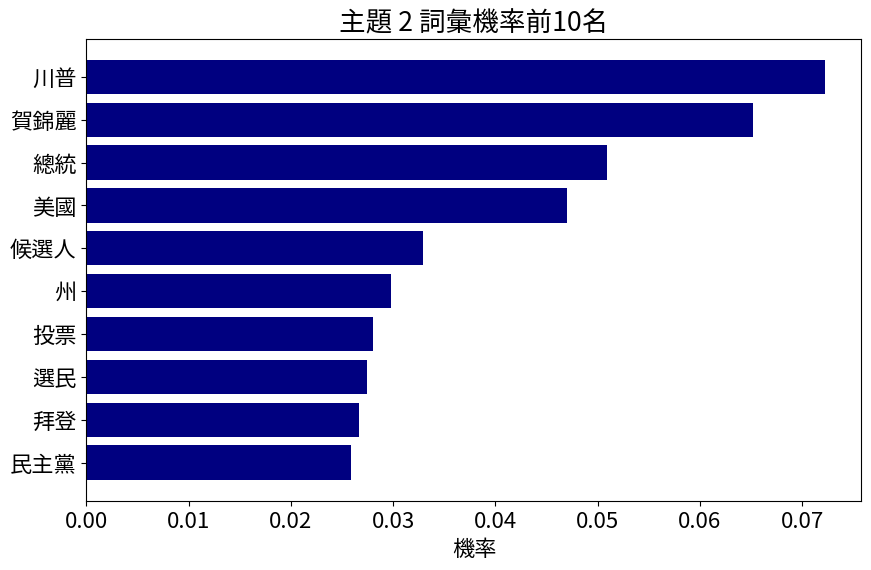

In [ ]:
# 視覺化顯示主題-詞彙分佈
topic_n = 2
data = zh_topic_model.get_topic(topic_n)

# 轉換為DataFrame
df = pd.DataFrame(data, columns=['word', 'prob'])
df = df[df['word'] != ' ']

# 根據prob排序並選出前10名
top_10 = df.sort_values('prob', ascending=False).head(10)

# 畫出長條圖
plt.figure(figsize=(10,6))
plt.barh(top_10['word'], top_10['prob'], color='navy')
plt.xlabel('機率')
plt.title(f'主題 {topic_n} 詞彙機率前10名')
plt.gca().invert_yaxis()
plt.show()

### 載入 OpenAI API 並定義 GPT 詮釋函數  
讀取 API 金鑰並定義 `call_gpt()` 函數，將主題關鍵詞餵入 GPT 模型，讓其自動產生主題分類（例如：體育、國際、財經）。


In [ ]:
# 讀取API key
with open("gpt_api_key.txt", "r", encoding="utf-8") as f:
    key = f.read().strip()

In [ ]:
client = OpenAI(api_key=key)
def call_gpt(keywords):
    try:
        prompt = f"""
            以下是一群新聞文章的代表性關鍵詞：{', '.join(keywords)}
            請判斷這些關鍵詞最有可能屬於哪一類新聞主題？（請只回覆：體育、國際、財經）
        """
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.8
        )
        output = response.choices[0].message.content.strip()
        return output
    except Exception as e:
        print(f"⚠️ Error: {e}")
        return ""

### 擷取主題關鍵詞並傳入 GPT 模型解讀  
取得每個主題的前 10 個關鍵詞，依序送入 GPT 模型進行詮釋，並將主題標籤回填至原始資料中。


In [ ]:
# 擷取主題關鍵詞
topic_keywords = {
    topic: [w[0] for w in zh_topic_model.get_topic(topic)[:10]]
    for topic in zh_topic_model.get_topics().keys()
    if topic != -1
}


# 執行 GPT 詮釋
gpt_labels = {}
for topic_id, keywords in tqdm(topic_keywords.items(), desc="GPT 詮釋主題中"):
    label = call_gpt(keywords)
    gpt_labels[topic_id] = label
    time.sleep(1.5)

# 對應至主資料
ebc['topic'] = topics
ebc['gpt_topic'] = ebc['topic'].map(gpt_labels)

GPT 詮釋主題中: 100%|██████████| 25/25 [00:46<00:00,  1.85s/it]


In [ ]:
ebc['gpt_topic'].value_counts()

,count
gpt_topic,
國際,2310
體育,1606
財經,796


### 分類評估：GPT 詮釋 vs 原始分類  
比較 GPT 所標註之主題（`gpt_topic`）與原始分類（`artCatagory`）之間的對應關係，輸出分類報告與混淆矩陣。


In [ ]:
# 假設這兩個是你資料中的欄位
# y_true: 原始標籤，例如 'artCatagory'
# y_pred: GPT 命名主題，例如 'gpt_topic'
df_eval = ebc[['artCatagory', 'gpt_topic']].dropna()
y_true = df_eval['artCatagory'].astype(str)
y_pred = df_eval['gpt_topic'].astype(str)

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

          國際       0.97      0.94      0.95      2388
          財經       0.84      0.91      0.87       728
          體育       0.98      0.99      0.99      1596

    accuracy                           0.95      4712
   macro avg       0.93      0.95      0.94      4712
weighted avg       0.95      0.95      0.95      4712



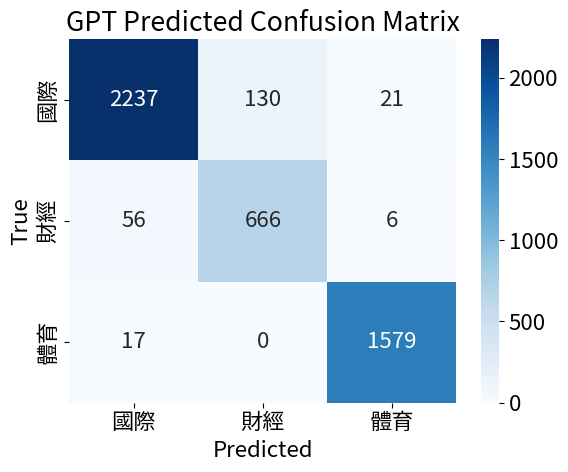

In [ ]:
# 仍使用剛剛清理過的 df_eval
df_eval = ebc[['artCatagory', 'gpt_topic']].dropna()
df_eval = df_eval[df_eval['gpt_topic'] != "其他"]
y_true = df_eval['artCatagory'].astype(str)
y_pred = df_eval['gpt_topic'].astype(str)

# 計算混淆矩陣
labels = sorted(list(set(y_true) | set(y_pred)))  # 所有出現過的類別
cm = confusion_matrix(y_true, y_pred, labels=labels)

# 畫圖
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("GPT Predicted Confusion Matrix")
plt.tight_layout()
plt.show()

### 錯誤預測分析  
將 GPT 分類錯誤的樣本找出，並附上其主題關鍵詞，幫助使用者理解 GPT 可能誤判的語意區塊。


In [ ]:
# 建立主題ID對應的前10個關鍵字字串（用逗號串起來）
topic_keywords_map = {
    topic_id: ", ".join([word for word, _ in zh_topic_model.get_topic(topic_id)[:10]])
    for topic_id in zh_topic_model.get_topics().keys()
    if topic_id != -1
}

# 把主題關鍵字欄位加到 ebc_raw 或 df_eval
df_eval['topic_keywords'] = ebc['topic'].map(topic_keywords_map)

# 篩選錯誤預測的資料
df_misclassified = df_eval[df_eval['artCatagory'] != df_eval['gpt_topic']]

# 顯示錯誤樣本 + 所屬主題關鍵詞
df_misclassified.head()



,artCatagory,gpt_topic,topic_keywords
0,財經,國際,"麵, 店, 吃, 料理, 嘉義, 台灣, 業者, 餐廳, 日本, 百貨"
26,財經,國際,"麵, 店, 吃, 料理, 嘉義, 台灣, 業者, 餐廳, 日本, 百貨"
58,財經,國際,"麵, 店, 吃, 料理, 嘉義, 台灣, 業者, 餐廳, 日本, 百貨"
84,財經,國際,"麵, 店, 吃, 料理, 嘉義, 台灣, 業者, 餐廳, 日本, 百貨"
89,財經,國際,"麵, 店, 吃, 料理, 嘉義, 台灣, 業者, 餐廳, 日本, 百貨"


### 建立 KeyBERT 表徵模型
使用 KeyBERTInspired 取代預設 TF-IDF，讓每個主題的代表詞更加語意導向。


In [ ]:
from bertopic.representation import KeyBERTInspired
# KeyBERT
keybert = KeyBERTInspired()

# 設定HDBscan模型
hdbscan_model = HDBSCAN(min_cluster_size=5, min_samples=30)

# 定義我們要用到的representation model（同學如果想比較其他模型可以在這邊加入其他模型方法）
representation_model = {
    "KeyBERT": keybert,
}

### 使用 KeyBERT 建立語意主題模型
結合 BERT 向量、jieba 分詞與 KeyBERT 表徵模型，建立語意導向的 BERTopic 主題模型。


In [ ]:
# 建立BERTopic模型
representation_topic_model = BERTopic(
  # Sub-models
  embedding_model=bert_ch,
  vectorizer_model=jieba_vectorizer,
  # 設定Representation model
  representation_model=representation_model,
  # Hyperparameters
  top_n_words=30,
  verbose=True,
  hdbscan_model=hdbscan_model,
)

# Train model
topics, probs = representation_topic_model.fit_transform(docs_zh, embeddings)

2025-05-10 08:55:49,825 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-10 08:55:57,099 - BERTopic - Dimensionality - Completed ✓
2025-05-10 08:55:57,100 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-10 08:55:57,217 - BERTopic - Cluster - Completed ✓
2025-05-10 08:55:57,222 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-10 08:56:19,748 - BERTopic - Representation - Completed ✓


In [ ]:
# 觀察KeyBERT微調後的主題表示
representation_topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,Representative_Docs
0,-1,605,-1_美國_東森_中國_北韓,"[美國, 東森, 中國, 北韓, 新聞, 市場, , 公司, 晶片, 台灣, 川普, 投資...","[半導體, 台積電, 英特爾, 消費者, 投資人, 馬斯克, 俄羅斯, 中央社, 晶片, 億美元]",[來襲專家北京意圖宣示美出口管制無效中國公司深度求索發布低成本人工智慧模型震撼股市也拉響華府...
1,0,1626,0_中華隊_台灣_陳_棒球,"[中華隊, 台灣, 陳, 棒球, 投手, 球迷, 世界, 賽, 比賽, 經典, 球員, 日本...","[委內瑞拉, 多明尼加, 尼加拉瓜, 資格賽, 日本隊, 全壘打, 台灣隊, 中華隊, 投手...",[強看東森中華隊開幕戰擊敗韓國韓媒全崩潰台北慘案世界棒球強賽昨日中華隊憑藉陳晨威的滿貫砲及台...
2,1,1293,1_一名_歲_警方_男子,"[一名, 歲, 警方, 男子, 發生, 發現, 新聞, 女子, , 中, 東森, 事件, ...","[消費者, 沒想到, 關注, 這名, 逮捕, 快來, 透露, 週刊, 畫面, 膠原]",[疑玩手機分心駕駛害車追撞無辜男慘被夾死車內泰國芭堤雅日前發生一起嚴重車禍導致一人死亡多人受...
3,2,208,2_仁勳_黃_輝達_房價,"[仁勳, 黃, 輝達, 房價, 萬, 貸款, 東森, 大小事, 萬元, 執行長, 央行, 民...","[台積電, 董事長, 執行長, 房子, 專家, 快來, 土地, 嘉義, 容積率, 央行]",[黃仁勳台北第一站剪頭髮將參加輝達緯創尾牙黃仁勳旋風今天席捲台北他的行程滿檔一早先去剪頭髮以...
4,3,180,3_川普_賀錦麗_總統_美國,"[川普, 賀錦麗, 總統, 美國, 候選人, 州, 拜登, 投票, 選民, 民主黨, 辯論,...","[美國民主黨, 美國共和黨, 威斯康辛, 民主黨, 共和黨, 總統大選, 支持者, 馬斯克,...",[封關民調和川普打成平手民主黨對賀錦麗選情悲觀美國總統大選月號即將登場紐約時報發布選前最後一...
5,4,148,4_航空_飛機_事故_機場,"[航空, 飛機, 事故, 機場, 客機, 空難, 濟州, 降落, 乘客, 班機, 一架, 航...","[機組人員, 飛行員, 直升機, 亞塞拜然, 國際機場, 罹難者, 航空公司, 架飛機, 哈...",[非罕見卻成巨大威脅盤點鳥擊導致墜機著名事件韓國濟州航空客機昨日降落時衝出跑道撞上圍籬外牆爆...
6,5,144,5_地震_大雪_民眾_積雪,"[地震, 大雪, 民眾, 積雪, 日本, 颱風, 地區, 發生, 影響, 降下, 洪水, 公...","[冷空氣, 北海道, 氣象廳, 龍捲風, 迎來, 快來, 持續, 淹水, 至少, 車輛]",[日本寒流持續沿海多地連日大雪石川大雪警報日本迎來連休卻碰上最長寒流氣象廳預計部份地區大雪將...
7,6,133,6_尹錫悅_戒嚴_南韓_總統,"[尹錫悅, 戒嚴, 南韓, 總統, 國會, 彈劾, 彈劾案, 執政黨, 國民, 在野黨, 議...","[民主黨, 第一夫人, 大韓民國, 民進黨, 執政黨, 國防部長, 國會議員, 反對黨, 在...",[最短命南韓突進緊急戒嚴小時後尹錫悅同意解除南韓總統尹錫悅昨日晚間突然宣布國家進入緊急戒嚴引...
8,7,122,7_網友_台股_股價_投資,"[網友, 台股, 股價, 投資, 東森, 買, 財經, 投資人, 股票, 狄驤, 市場, 股...","[財經新聞, 台積電, 分析師, 投資人, 示意圖, 專家, 取自, 看好, 指數, 股添樂]",[買台積賠了萬不賣就不虧家人逼停損他不解網熱議台積電今日重返千金但先前在月領軍台股創下歷史新...
9,8,115,8_早盤_來到_元漲_元,"[早盤, 來到, 元漲, 元, 漲幅, 逾, 族群, 台股, 股, 震盪, 最低, 下探, ...","[開低走高, 元鴻海, 逾鴻海, 概念股, 取自, 指數, 個股, 漲停, 元跌元, 權值]",[電子倒一片台股下跌點台塑四寶不忍了逆勢撐盤台股今日早盤開高走低開小漲後出現一波急殺最低下探...


In [ ]:
representation_topic_model.visualize_topics()

### 擷取 KeyBERT 主題詞並傳入 GPT
使用 representation_topic_model 中每個主題的 KeyBERT 詞彙作為語意詮釋輸入，讓 GPT 給出主題分類。


In [ ]:
# 擷取 representation_topic_model.get_topic_info() 中的 KeyBERT 詮釋詞
topic_info_df = representation_topic_model.get_topic_info()

# 建立主題對應關鍵詞字典（用 KeyBERT 詮釋的代表詞，逗號分隔）
rep_topic_keywords_for_gpt = {
    row['Topic']: row['KeyBERT']
    for _, row in topic_info_df.iterrows()
    if row['Topic'] != -1
}

In [ ]:
# 執行 GPT 詮釋（使用 KeyBERT 詞）
gpt_labels_rep = {}
for topic_id, keywords in tqdm(rep_topic_keywords_for_gpt.items(), desc="GPT 詮釋 representation 主題中"):
    label = call_gpt(keywords)
    gpt_labels_rep[topic_id] = label
    time.sleep(1.5)

# 對應回文章資料
ebc['rep_topic'] = representation_topic_model.get_document_info(docs_zh)['Topic']
ebc['gpt_rep_topic'] = ebc['rep_topic'].map(gpt_labels_rep)

GPT 詮釋 representation 主題中: 100%|██████████| 20/20 [00:37<00:00,  1.90s/it]


In [ ]:
ebc['gpt_rep_topic'].value_counts()

,count
gpt_rep_topic,
國際,1740
體育,1399
財經,698


In [ ]:
df_eval = ebc[['artCatagory', 'gpt_rep_topic']].dropna()
y_true = df_eval['artCatagory'].astype(str)
y_pred = df_eval['gpt_rep_topic'].astype(str)

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

          國際       0.84      0.95      0.89      1551
          財經       0.89      0.89      0.89       700
          體育       0.95      0.84      0.89      1586

    accuracy                           0.89      3837
   macro avg       0.90      0.89      0.89      3837
weighted avg       0.90      0.89      0.89      3837



### 結合 KeyBERT 與 MMR 的主題表示
MMR 可減少詞彙重複、提升多樣性；與 KeyBERT 搭配能平衡語意中心與資訊覆蓋。


In [ ]:
# Step 1：建立主題ID對應的 KeyBERT 語意關鍵詞（字串格式）
rep_topic_info_df = representation_topic_model.get_topic_info()
rep_topic_keywords_map = {
    row['Topic']: row['KeyBERT']
    for _, row in rep_topic_info_df.iterrows()
    if row['Topic'] != -1
}

# Step 2：建立資料集（包含 content）
df_eval_rep = ebc[['content', 'artCatagory', 'rep_topic', 'gpt_rep_topic']].dropna()
df_eval_rep['topic_keywords'] = df_eval_rep['rep_topic'].map(rep_topic_keywords_map)

# Step 3：篩選 GPT 預測錯誤的樣本
df_misclassified_rep = df_eval_rep[
    df_eval_rep['artCatagory'].astype(str) != df_eval_rep['gpt_rep_topic'].astype(str)
]

# Step 4：顯示錯誤樣本（包含 content）
df_misclassified_rep[['content', 'artCatagory', 'gpt_rep_topic', 'topic_keywords']].head()


,content,artCatagory,gpt_rep_topic,topic_keywords
69,野生捕捉結束白宮會議黃仁勳暢談未來布局美國白宮召集了科技七巨頭的高層針對和能源議題洽談當時輝...,財經,國際,"[巴拿馬運河, 聯合國, 行政命令, 習近平, 半導體, 加拿大, 墨西哥, 消費者, 巴拿..."
91,千億豪門婚姻破滅林鴻南王婉玲親揭婚變內幕千億豪門婚姻破滅橫跨金融建設產業的千億宏泰集團掌門人...,財經,國際,"[消費者, 沒想到, 關注, 這名, 逮捕, 快來, 透露, 週刊, 畫面, 膠原]"
133,擁張台積電仍嚴守紀律他們雨天寧騎也不搭小黃如果你是千萬身價的富翁如果沒有捷運可搭你會選擇叫小...,財經,國際,"[美國國防部, 習近平, 國防部, 無人機, 菲律賓, 發言人, 金融時報, 賴清德, 關注..."
181,鬼故事又來了外資淨空單近萬口專家勸要尊重台股今日收漲點以點作收盤後公布三大法人買賣超三大法人...,財經,國際,"[冷空氣, 北海道, 氣象廳, 龍捲風, 迎來, 快來, 持續, 淹水, 至少, 車輛]"
184,年薪買萬預售屋他見一堆人貸款沒過嚇傻有些人努力存錢只為了想要擁有一間屬於自己的房子不過辛辛苦...,財經,國際,"[冷空氣, 北海道, 氣象廳, 龍捲風, 迎來, 快來, 持續, 淹水, 至少, 車輛]"


In [ ]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance

# 定義兩個 representation model
keybert = KeyBERTInspired()
mmr = MaximalMarginalRelevance(diversity=0.3)

# 建立混合式 representation 模型（KeyBERT + MMR）
representation_model = {
    "KeyBERT": keybert,
    "MMR": mmr
}

# 建立 BERTopic 模型（使用 representation model）
mixed_rep_topic_model = BERTopic(
    embedding_model=bert_ch,
    vectorizer_model=jieba_vectorizer,
    representation_model=representation_model,
    hdbscan_model=hdbscan_model,
    top_n_words=30,
    verbose=True
)

# 執行主題建模
topics, probs = mixed_rep_topic_model.fit_transform(docs_zh, embeddings)


2025-05-10 09:00:35,204 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-10 09:00:47,423 - BERTopic - Dimensionality - Completed ✓
2025-05-10 09:00:47,435 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-10 09:00:47,662 - BERTopic - Cluster - Completed ✓
2025-05-10 09:00:47,667 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-10 09:01:14,592 - BERTopic - Representation - Completed ✓


In [ ]:
mixed_rep_topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,MMR,Representative_Docs
0,-1,665,-1_美國_東森_公司_中國,"[美國, 東森, 公司, 中國, 新聞, , 北韓, 市場, 台灣, 川普, 晶片, 中,...","[半導體, 台積電, 英特爾, 消費者, 董事長, 執行長, 關注, 無人機, 俄羅斯, 晶片]","[東森, 公司, 川普, 晶片, 指出, 指數, 立場, 大小事, 民眾, 輝達]",[衝擊美股輝達跌近市值蒸發兆中國新創公司成為大黑馬號稱以低成本打造震撼美股衝擊科技股尤其龍頭...
1,0,1622,0_中華隊_台灣_陳_棒球,"[中華隊, 台灣, 陳, 棒球, 投手, 球迷, 世界, 賽, 比賽, 經典, 球員, 日本...","[委內瑞拉, 多明尼加, 尼加拉瓜, 資格賽, 日本隊, 全壘打, 台灣隊, 中華隊, 投手...","[中華隊, 投手, 球迷, 資格賽, 選手, 聯盟, 先發, 傑憲, 加油, 西班牙]",[強賽台灣棒球世界上升至第辜仲諒被職棒拖累世界強即年底即將在台灣開打今天舉辦賽事記者會棒協理...
2,1,1272,1_一名_歲_警方_男子,"[一名, 歲, 警方, 男子, 發生, 發現, 女子, 新聞, , 中, 東森, 事件, ...","[消費者, 沒想到, 關注, 這名, 逮捕, 快來, 透露, 畫面, 週刊, 膠原]","[警方, 東森, 事件, 調查, 影片, 孩子, 優惠, 醫院, 關心, 指出]",[警定調是謀殺歲女學生下課失聯陳屍樹林被發現法國近日有名歲女學生被發現陳屍在一處偏僻的樹林中...
3,2,196,2_仁勳_黃_輝達_房價,"[仁勳, 黃, 輝達, 房價, 萬, 貸款, 東森, 央行, 大小事, 執行長, 說, 買,...","[台積電, 董事長, 執行長, 房子, 專家, 快來, 土地, 嘉義, 容積率, 央行]","[仁勳, 輝達, 貸款, 東森, 央行, 大小事, 執行長, 董事長, 業者, 台北]",[黃仁勳台北第一站剪頭髮將參加輝達緯創尾牙黃仁勳旋風今天席捲台北他的行程滿檔一早先去剪頭髮以...
4,3,177,3_川普_賀錦麗_總統_美國,"[川普, 賀錦麗, 總統, 美國, 候選人, 州, 投票, 選民, 民主黨, 拜登, 辯論,...","[美國民主黨, 美國共和黨, 威斯康辛, 民主黨, 共和黨, 總統大選, 支持者, 馬斯克,...","[川普, 候選人, 選民, 民主黨, 拜登, 共和黨, 選舉人, 總統大選, 馬斯克, 支持者]",[封關民調和川普打成平手民主黨對賀錦麗選情悲觀美國總統大選月號即將登場紐約時報發布選前最後一...
5,4,149,4_航空_飛機_事故_機場,"[航空, 飛機, 事故, 機場, 客機, 空難, 濟州, 降落, 乘客, 班機, 一架, 航...","[機組人員, 飛行員, 直升機, 亞塞拜然, 國際機場, 罹難者, 航空公司, 架飛機, 消...","[飛機, 客機, 空難, 航班, 機上, 墜毀, 起落架, 起飛, 失事, 罹難者]",[非罕見卻成巨大威脅盤點鳥擊導致墜機著名事件韓國濟州航空客機昨日降落時衝出跑道撞上圍籬外牆爆...
6,5,142,5_地震_大雪_積雪_民眾,"[地震, 大雪, 積雪, 民眾, 日本, 地區, 颱風, 發生, 影響, 降下, 洪水, 公...","[冷空氣, 北海道, 氣象廳, 龍捲風, 迎來, 快來, 持續, 淹水, 至少, 車輛]","[地震, 降雪, 停電, 災情, 北海道, 警報, 氣象廳, 登陸, 強風, 至少]",[日本寒流持續沿海多地連日大雪石川大雪警報日本迎來連休卻碰上最長寒流氣象廳預計部份地區大雪將...
7,6,141,6_尹錫悅_戒嚴_南韓_總統,"[尹錫悅, 戒嚴, 南韓, 總統, 國會, 彈劾, 彈劾案, 執政黨, 國民, 在野黨, 議...","[民主黨, 第一夫人, 大韓民國, 民進黨, 執政黨, 國會議員, 國防部長, 反對黨, 在...","[尹錫悅, 彈劾案, 執政黨, 在野黨, 民主黨, 金建希, 解除戒嚴, 韓東勳, 民眾, 首爾]",[反對親北韓勢力南韓突宣布戒嚴僅小時落幕南韓總統尹錫悅昨晚突襲式宣布進入緊急戒嚴以保護國家不...
8,7,131,7_網友_台股_股價_投資,"[網友, 台股, 股價, 投資, 東森, 買, 投資人, 市場, 財經, 狄驤, 股市, 股...","[財經新聞, 台積電, 分析師, 投資人, 示意圖, 專家, 取自, 看好, 指數, 賣出]","[東森, 投資人, 財經, 狄驤, 股市, 封面, 台積電, 指出, 言論, 台積]",[支股只有檔賺他哀怎會買成這樣網笑跟自己對作就穩了台股自今年月以來整體多在點至點左右區間震盪...
9,8,116,8_美國_中國_關稅_川普,"[美國, 中國, 關稅, 川普, 台灣, 總統, 晶片, 加拿大, 國家, 習近平, 經濟,...","[巴拿馬運河, 聯合國, 習近平, 半導體, 加拿大, 墨西哥, 消費者, 巴拿馬, 措施,...","[關稅, 川普, 晶片, 加拿大, 習近平, 墨西哥, 拜登, 巴拿馬, 消費者, 加徵]",[川普徵稅遭批最蠢貿易戰美前財長幫習近平大忙美國總統川普對加拿大墨西哥徵收進口關稅加墨兩國領...


In [ ]:
topic_info = mixed_rep_topic_model.get_topic_info()
topic_keywords_for_gpt = {
    row['Topic']: row['MMR']
    for _, row in topic_info.iterrows()
    if row['Topic'] != -1
}


In [ ]:
# 執行 GPT 詮釋（使用 KeyBERT 詞）
gpt_labels_rep = {}
for topic_id, keywords in tqdm(topic_keywords_for_gpt.items(), desc="GPT 詮釋 MMR 主題中"):
    label = call_gpt(keywords)
    gpt_labels_rep[topic_id] = label
    time.sleep(1.5)

# 對應回文章資料
ebc['MMR_topic'] = mixed_rep_topic_model.get_document_info(docs_zh)['Topic']
ebc['gpt_MMR_topic'] = ebc['rep_topic'].map(gpt_labels_rep)

GPT 詮釋 MMR 主題中: 100%|██████████| 20/20 [00:37<00:00,  1.88s/it]


In [ ]:
df_eval = ebc[['artCatagory', 'gpt_MMR_topic']].dropna()
y_true = df_eval['artCatagory'].astype(str)
y_pred = df_eval['gpt_MMR_topic'].astype(str)

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

          國際       0.79      0.90      0.84      1551
          財經       0.77      0.74      0.76       700
          體育       0.95      0.84      0.89      1586

    accuracy                           0.85      3837
   macro avg       0.84      0.83      0.83      3837
weighted avg       0.85      0.85      0.85      3837



### 不同主題表示方式的分類效能比較
本表比較 TF-IDF、KeyBERT、MMR 三種主題關鍵詞對 GPT 詮釋準確性的影響。


In [ ]:

# 建立報告
report1 = classification_report(df1['artCatagory'], df1['gpt_topic'], output_dict=True)
report2 = classification_report(df2['artCatagory'], df2['gpt_rep_topic'], output_dict=True)
report3 = classification_report(df3['artCatagory'], df3['gpt_MMR_topic'], output_dict=True)

# 取 weighted avg 的 precision/recall/f1-score
summary_df = pd.DataFrame({
    "TF-IDF": {
        "Precision": report1["weighted avg"]["precision"],
        "Recall": report1["weighted avg"]["recall"],
        "F1-score": report1["weighted avg"]["f1-score"],
    },
    "KeyBERT": {
        "Precision": report2["weighted avg"]["precision"],
        "Recall": report2["weighted avg"]["recall"],
        "F1-score": report2["weighted avg"]["f1-score"],
    },
    "MMR": {
        "Precision": report3["weighted avg"]["precision"],
        "Recall": report3["weighted avg"]["recall"],
        "F1-score": report3["weighted avg"]["f1-score"],
    }
})

# 顯示
summary_df = summary_df.round(3).T  # 轉置 & 四捨五入
summary_df


,Precision,Recall,F1-score
TF-IDF,0.953,0.951,0.952
KeyBERT,0.898,0.892,0.892
MMR,0.854,0.846,0.847


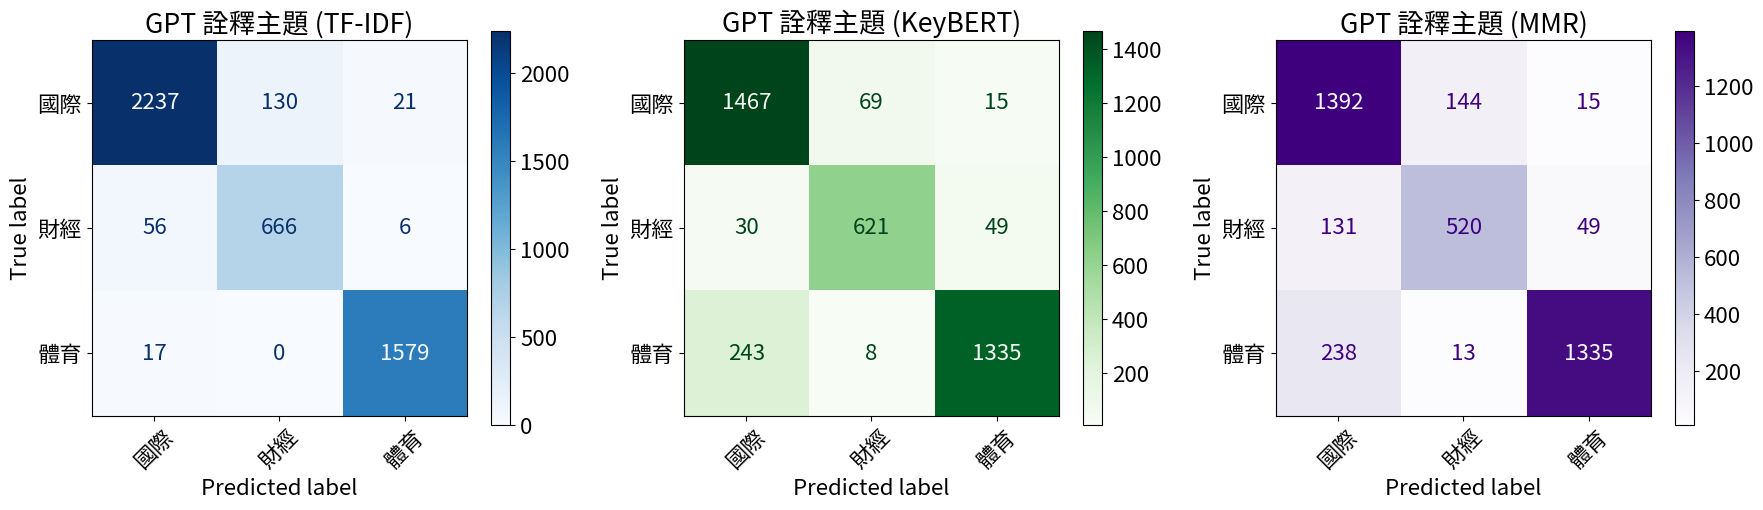

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 建立三組評估資料（去除缺值）
df1 = ebc[['artCatagory', 'gpt_topic']].dropna()
df2 = ebc[['artCatagory', 'gpt_rep_topic']].dropna()
df3 = ebc[['artCatagory', 'gpt_MMR_topic']].dropna()

# 指定要統一的標籤集（確保三個混淆矩陣可比較）
labels = sorted(set(df1['artCatagory']) | set(df2['artCatagory']) | set(df3['artCatagory']))

# 建立混淆矩陣
cm1 = confusion_matrix(df1['artCatagory'], df1['gpt_topic'], labels=labels)
cm2 = confusion_matrix(df2['artCatagory'], df2['gpt_rep_topic'], labels=labels)
cm3 = confusion_matrix(df3['artCatagory'], df3['gpt_MMR_topic'], labels=labels)

# 畫圖
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# GPT 預設（TF-IDF）
ConfusionMatrixDisplay(cm1, display_labels=labels).plot(ax=axes[0], xticks_rotation=45, cmap='Blues', values_format='d')
axes[0].set_title("GPT 詮釋主題 (TF-IDF)")

# GPT + KeyBERT
ConfusionMatrixDisplay(cm2, display_labels=labels).plot(ax=axes[1], xticks_rotation=45, cmap='Greens', values_format='d')
axes[1].set_title("GPT 詮釋主題 (KeyBERT)")

# GPT + MMR
ConfusionMatrixDisplay(cm3, display_labels=labels).plot(ax=axes[2], xticks_rotation=45, cmap='Purples', values_format='d')
axes[2].set_title("GPT 詮釋主題 (MMR)")

plt.tight_layout()
plt.show()
